In [1]:
%env CUDA_VISIBLE_DEVICES=1
%env LIBRARY_PATH=/usr/local/cuda/lib64
import sys
sys.path.append("/home/shirobokov/.local/lib/python3.6/site-packages/")

env: CUDA_VISIBLE_DEVICES=1
env: LIBRARY_PATH=/usr/local/cuda/lib64


In [2]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [3]:
import h5py
import torch

/opt/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [82]:
import os
list_of_images = []
list_of_masks = []
list_of_private = []
with open("/home/shirobokov/data/Images_2_data/pub/gt.txt", 'r') as file:
    for line in file:
        name = line.split()[1]
        list_of_images.append(plt.imread(os.path.join("/home/shirobokov/data/Images_2_data/pub/images", name)))
        list_of_masks.append(plt.imread(os.path.join("/home/shirobokov/data/Images_2_data/pub/gt", name)))
masks = np.array(list_of_masks)        
images = np.array(list_of_images)
images = images.transpose((0, 3, 1, 2))
print(masks.shape, images.shape)

(63, 213, 320) (63, 3, 213, 320)


In [84]:
# flattener = torch.nn.Sequential()

# flattener.add_module("flat", Flatten())
# flattener(Variable(torch.FloatTensor(masks)))

In [85]:
Val_images = images[-10:]
Val_masks = masks[-10:]
images = images[:-10]
masks = masks[:-10]

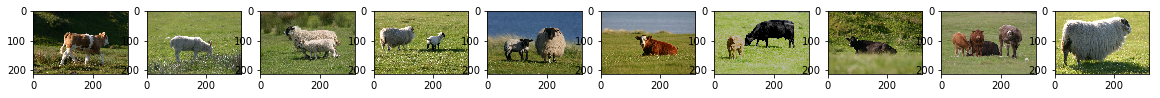

In [86]:
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow(Val_images[i].transpose(1,2,0))

In [9]:
Val_masks.shape

(10, 213, 320)

In [10]:
masks.shape

(53, 213, 320)

In [203]:
def make_crops(images, size=9):
    crops = np.zeros((68160 * len(images), 3, size, size))
    half_size = size // 2
    calc = 0
    for image in images:
        image = np.pad(image, ((0,0), (half_size, half_size), (half_size, half_size)),
                       'constant', constant_values=0)
        for i in range(half_size, image.shape[1] - half_size):
            for j in range(half_size, image.shape[2] - half_size):
                crop = image[:, i - half_size: i + half_size + 1, j - half_size:j + half_size + 1]
                crops[calc] = crop
                calc += 1
    return crops

In [12]:
y_train = []
for mask in masks:
    y_train.extend(mask.ravel())
y_train = np.array(y_train)    

#y_label = np.array([y_label == i for i in range(2)]).T
print(y_train.shape)


y_test = []
for mask in Val_masks:
    y_test.extend(mask.ravel())
y_test = np.array(y_test)
print(y_test.shape)


(3612480,)
(681600,)


In [13]:
X_train = make_crops(images)
X_test = make_crops(Val_images)

print(X_train.shape, X_test.shape)

3612480
681600
(3612480, 3, 9, 9) (681600, 3, 9, 9)


In [202]:
from sklearn.metrics import accuracy_score


#from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(crops, y_label, test_size=0.1)
# print(X_train.shape, y_train.shape)

In [211]:
model = torch.nn.Sequential()
model.add_module('conv_1', nn.Conv2d(3, 64, kernel_size=(3, 3), stride=1, padding=0))
#model.add_module("maxpool_1", torch.nn.MaxPool2d(kernel_size=2))
model.add_module("bn1", torch.nn.BatchNorm2d(64))
model.add_module("relu_1", torch.nn.ReLU())

model.add_module('conv_2', nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, padding=0))
model.add_module("bn2", torch.nn.BatchNorm2d(128))
model.add_module("relu_2", torch.nn.ReLU())
                 
model.add_module('conv_3', nn.Conv2d(128, 256, kernel_size=(3,3), stride=1, padding=0))
model.add_module("bn3", torch.nn.BatchNorm2d(256))
model.add_module("relu_3", torch.nn.ReLU())                 


model.add_module("flat", Flatten())

model.add_module("fc1", torch.nn.Linear(2304, 512))
model.add_module("relu_4", torch.nn.ReLU())
model.add_module("dropout_4", torch.nn.Dropout(p=0.5))
model.add_module("fc5", torch.nn.Linear(512, 1024))
model.add_module("relu_5", torch.nn.ReLU())

model.add_module("fc6", torch.nn.Linear(1024, 2))
model.add_module("sigmoid", torch.nn.LogSoftmax(1))

model.cuda(0)

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (relu_2): ReLU()
  (conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (relu_3): ReLU()
  (flat): Flatten(
  )
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (relu_4): ReLU()
  (dropout_4): Dropout(p=0.5)
  (fc5): Linear(in_features=512, out_features=1024, bias=True)
  (relu_5): ReLU()
  (fc6): Linear(in_features=1024, out_features=2, bias=True)
  (sigmoid): LogSoftmax()
)

In [210]:
model(Variable(torch.FloatTensor(X_test[0][None])))

Variable containing:
-0.7133 -0.6733
[torch.FloatTensor of size 1x2]

In [18]:
# An auxilary function that returns mini-batches for neural network training
from tqdm import trange
def iterate_minibatches(X, y, batchsize, shuffle=False):
    indices = np.arange(len(X))
    if shuffle: 
        indices = np.random.permutation(indices)
    for start in trange(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [213]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [215]:
import time
from pandas import ewma
from IPython import display

num_epochs = 5 #amount of passes through the data
batch_size = 1024 #number of samples processed at each function call
auc_history = []

In [ ]:
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    
    train_err = train_acc = 0
    start_time = time.time()
    
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
        X_batch = Variable(torch.FloatTensor(X_batch)).cuda(0)
        y_batch = Variable(torch.LongTensor(y_batch)).cuda(0)
        
        y_predicted = model(X_batch)
        loss = torch.nn.functional.nll_loss(y_predicted, y_batch).mean()
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_err += loss.data.cpu().numpy()[0]
        train_acc += torch.eq(torch.max(y_predicted, 1)[1], y_batch).data.cpu().numpy().mean()

    # And a full pass over the validation data:
    y_pred = []
    
    model.train(False)
    for X_batch, y_batch in iterate_minibatches(X_test, y_test, batch_size, shuffle=False):
        X_batch = Variable(torch.FloatTensor(X_batch)).cuda(0)
        y_pred.extend(model(X_batch).data.cpu().numpy())
        
    y_pred = np.asarray(y_pred)
        
    val_acc = accuracy_score(y_test, np.argmax(y_pred, 1))
    #val_roc_auc = roc_auc_score(y_test, y_pred)
    auc_history.append(val_acc)
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.title("Validation AUC")
    plt.xlabel("#iteration")
    plt.ylabel("AUC")
    plt.plot(auc_history, 'b',label='val auc')
    plt.plot(ewma(np.array(auc_history), span=10),'r',label='ewm val auc')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    train_batches = np.ceil(len(X_train) / batch_size)
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc * 100))
    #print("  validation roc_auc:\t\t{:.2f} %".format(val_roc_auc * 100))

  5%|▍         | 162/3528 [00:13<04:47, 11.73it/s]

In [22]:
#torch.save(model, "HW_1_dummy.pt")

/home/shirobokov/.local/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [24]:
# kek = torch.load("HW_1_dummy.pt")

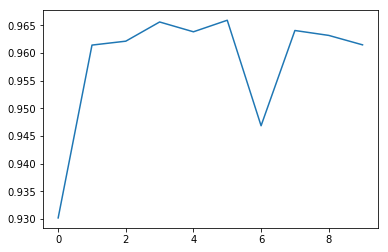

In [219]:
plt.plot(auc_history)

## Pair staff

In [36]:
from scipy.signal import convolve2d


def create_filter(row, col, val=-1, center_value=1):
    filters = np.array([[0,0,0],
                        [0,center_value,0],
                        [0,0,0]])
    filters[row, col] = val
    return filters


from functools import reduce
def get_pair_potential(image, filters, A=0, B=1, sigma=1):
    pairwise_diff = np.array(
                    [reduce(lambda x, y: x + y,
                        [convolve2d(image[channel], filters[index], mode='same', boundary='symm') ** 2 for channel in range(3)])
                    for index in range(4)]
            )
    return A + B * np.exp(- pairwise_diff / 2 / sigma ** 2)

### Graph creation

In [110]:
index = 6
image_to_test = Val_images[index]
mask_to_test = Val_masks[index]

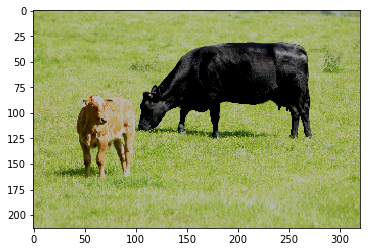

In [111]:
plt.imshow(image_to_test.transpose(1, 2, 0))

In [15]:
# model = torch.load("torch_big.pt")

In [ ]:
#model.cuda(0)

In [112]:
y_predicted = []
for X_b, y_b in iterate_minibatches(make_crops(image_to_test[None]), make_crops(image_to_test[None]), 10000):
    y_predicted.extend(model(Variable(torch.FloatTensor(X_b).cuda(0))).data.cpu().numpy())
y_predicted = np.array(y_predicted)

  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


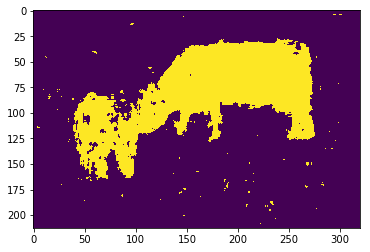

In [113]:
logic_mask = (np.exp(y_predicted)[:, 1] >0.5)
plt.imshow(logic_mask.reshape(213,320))

In [162]:
#nn_pred = - model(Variable(torch.FloatTensor(make_crops(image_to_test[None]))).cuda(0)).data.cpu().numpy()

nn_pred = []
for X_b, y_b in iterate_minibatches(make_crops(image_to_test[None]), make_crops(image_to_test[None]), 10000):
    nn_pred.extend(model(Variable(torch.FloatTensor(X_b).cuda(0))).data.cpu().numpy())
nn_pred = - np.array(nn_pred)

  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


100%|██████████| 7/7 [00:01<00:00,  5.70it/s]


In [163]:
import maxflow

def define_graph(image, nn_predictions):
    filters = [create_filter(row, col) for row, col in [(0, 1), (1, 2), (2, 1), (1, 0)]]
    filters = np.array(filters)
    graph_filters = [create_filter(row, col, val=1, center_value=0) for row, col in [(0, 1), (1, 2), (2, 1), (1, 0)]]
    graph_filters = np.array(graph_filters)


    g = maxflow.Graph[float]()
    nodes = g.add_grid_nodes(image.shape[1:])


    for weights, structure in zip(get_pair_potential(image, filters, A=1, B=1, sigma=1), graph_filters):
        g.add_grid_edges(nodes, weights, structure=structure) 
        
        
    kostyl = -np.log(np.clip(np.exp(-nn_predictions[:,1]) + 0.3, 0, 1))
    g.add_grid_tedges(nodes, kostyl.reshape(213, 320), nn_predictions[:, 0].reshape(213, 320))
    return g, nodes

In [164]:
g, nodes = define_graph(image_to_test, nn_pred)
g.maxflow() 

3630.252940755214

In [165]:
THE_learned_mask = g.get_grid_segments(nodes)

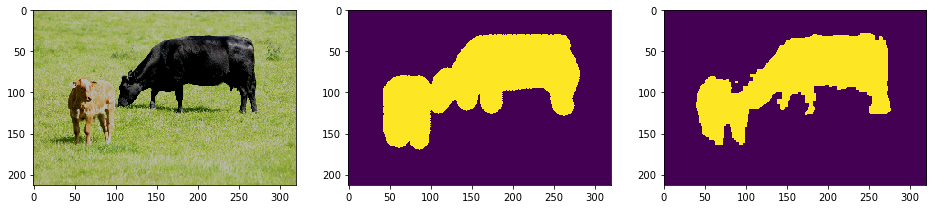

In [166]:
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.imshow(image_to_test.transpose(1,2,0))
plt.subplot(1,3,2)
plt.imshow(mask_to_test)
plt.subplot(1,3,3)
plt.imshow(THE_learned_mask)

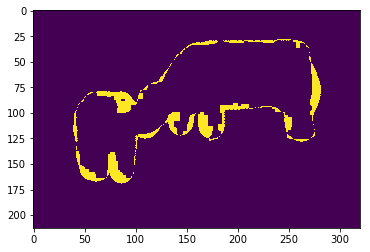

In [160]:
plt.imshow(np.logical_xor(THE_learned_mask, mask_to_test))

In [169]:
scores = []
for i in range(len(Val_images)):
    img = Val_images[i]
    mask_correct = Val_masks[i].astype(bool)
    #mask_nn = get_mask(img)
    #mask_predicted = segmentation(img, mask_nn)
    
    #pred = - model(Variable(torch.FloatTensor(make_crops(img[None]))).cuda(0)).data.cpu().numpy()
    nn_pred = []
    for X_b, y_b in iterate_minibatches(make_crops(img[None]), make_crops(img[None]), 10000):
        nn_pred.extend(model(Variable(torch.FloatTensor(X_b).cuda(0))).data.cpu().numpy())
    pred = - np.array(nn_pred)
    
    g, nodes = define_graph(img, pred)
    g.maxflow() 
    mask_predicted = g.get_grid_segments(nodes)
    
    print(np.logical_and(mask_correct, mask_predicted).sum(), (mask_correct + mask_predicted).sum())
    score = 2 * np.logical_and(mask_correct, mask_predicted).sum() / (
        mask_correct.sum() + mask_predicted.sum())
    print(score)
    scores.append(score)

  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


13259 17854
0.8523125381673256
68160


 14%|█▍        | 1/7 [00:00<00:00,  6.15it/s]

68160


100%|██████████| 7/7 [00:01<00:00,  6.49it/s]


7746 9663
0.8898845424780286
68160


 14%|█▍        | 1/7 [00:00<00:01,  5.88it/s]

68160


100%|██████████| 7/7 [00:01<00:00,  6.02it/s]


14657 16330
0.9460096169361345
68160


 14%|█▍        | 1/7 [00:00<00:01,  5.98it/s]

68160


100%|██████████| 7/7 [00:01<00:00,  6.33it/s]


10427 11832
0.9368794644862752
68160


 14%|█▍        | 1/7 [00:00<00:00,  6.30it/s]

68160


100%|██████████| 7/7 [00:01<00:00,  6.41it/s]


15202 17068
0.9421753951038115
68160


 14%|█▍        | 1/7 [00:00<00:01,  5.90it/s]

68160


100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


7288 7974
0.9550517625475036
68160


 14%|█▍        | 1/7 [00:00<00:00,  6.09it/s]

68160


100%|██████████| 7/7 [00:01<00:00,  6.31it/s]


15089 17951
0.9133777239709443
68160


 14%|█▍        | 1/7 [00:00<00:00,  6.01it/s]

68160


100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


6644 8329
0.8874641020503573


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


100%|██████████| 7/7 [00:01<00:00,  6.42it/s]


19177 21078
0.9527760526642653


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


29389 31589
0.9639214142805602


In [170]:
np.mean(scores)

0.9239852612685209

In [196]:
def segmentation(img, model):
    nn_pred = []
    for X_b, y_b in iterate_minibatches(make_crops(img[None]), make_crops(img[None]), 10000):
        nn_pred.extend(model(Variable(torch.FloatTensor(X_b).cuda(0))).data.cpu().numpy())
    pred = - np.array(nn_pred)
    
    g, nodes = define_graph(img, pred)
    g.maxflow() 
    return g.get_grid_segments(nodes)


from itertools import chain
def run_length_enc(label):
    x = label.transpose().flatten()
    y = np.where(x > 0)[0]
    z = np.where(np.diff(y) > 1)[0]
    start = np.insert(y[z+1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s+1, l+1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return res

In [179]:
list_of_private = []
list_of_private_names = []
for name in os.listdir("/home/shirobokov/data/Images_2_data/images"):
    if not str.startswith(name, "."):
        list_of_private_names.append(name)
        list_of_private.append(plt.imread(os.path.join("/home/shirobokov/data/Images_2_data/images", name)))
priv_images = np.array(list_of_private)
priv_images = priv_images.transpose((0, 3, 1, 2))
print(priv_images.shape)

(20, 3, 213, 320)


In [189]:
priv_mask = segmentation(priv_images[3], model)

  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


In [192]:
# plt.figure(figsize=(16,6))
# plt.subplot(1,2,1)
# plt.imshow(priv_images[3].transpose(1,2,0))
# plt.subplot(1,2,2)
# plt.imshow(priv_mask)

In [202]:
with open("solution.txt", 'w') as f:
    f.write("img,pixels\n")
    for image, name in zip(priv_images, list_of_private_names):
        priv_mask = segmentation(image, model)
        encoded = run_length_enc(priv_mask)
        f.write(name + ",")
        for value in encoded:
            f.write(str(value) + " ")
        f.write("\n")

  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


  0%|          | 0/7 [00:00<?, ?it/s]

68160
68160


100%|██████████| 7/7 [00:01<00:00,  6.36it/s]
